<a href="https://colab.research.google.com/github/sainadth/Malicious-Domain-Detection/blob/main/MDND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 0. Dependencies & Imports
!pip install pandas numpy scikit-learn tensorflow seaborn matplotlib --quiet

import pandas as pd
import numpy as np
import re, string, seaborn as sns, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix, roc_curve)
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from math import pi

# Set style for better plots
plt.style.use('default')  # Use default instead of seaborn-v0_8
sns.set_palette("husl")

print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Update file paths for local environment
BENIGN_FILE = "/content/drive/MyDrive/ColabNotebooks/majestic_million.csv"
DGA_FILE    = "/content/drive/MyDrive/ColabNotebooks/argencon.csv"

maj = pd.read_csv(BENIGN_FILE).rename(columns=lambda c: c.strip())
maj = maj[['Domain']].rename(columns={'Domain': 'domain'})
maj['label'] = 0
maj.drop_duplicates('domain', inplace=True)

dga = pd.read_csv(DGA_FILE).rename(columns=lambda c: c.strip())
dga = dga[['domain']]
dga['label'] = 1
dga.drop_duplicates('domain', inplace=True)

def is_valid(domain):
    pat = re.compile(r'^(?=.{1,253}$)(?!\-)([a-z0-9\-]{1,63}(?<!\-)\.)+[a-z]{2,63}$')
    return bool(pat.fullmatch(str(domain).lower()))

maj = maj[maj['domain'].apply(is_valid)]
dga = dga[dga['domain'].apply(is_valid)]

# REDUCED SAMPLE SIZE: Take only 50k from each class for faster processing
N = min(70000, len(maj), len(dga))  # Maximum 50k samples per class
maj_sample = maj.sample(N, random_state=42)
dga_sample = dga.sample(N, random_state=42)
data = pd.concat([maj_sample, dga_sample], ignore_index=True).drop_duplicates('domain').reset_index(drop=True)

print(f"Loaded {len(maj)} benign and {len(dga)} malicious domains")
print(f"Final reduced dataset: {len(data)} domains (50k each class for faster training)")

/tmp/ipython-input-636644311.py:10: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dga = pd.read_csv(DGA_FILE).rename(columns=lambda c: c.strip())


Loaded 999096 benign and 2917371 malicious domains
Final reduced dataset: 139552 domains (50k each class for faster training)


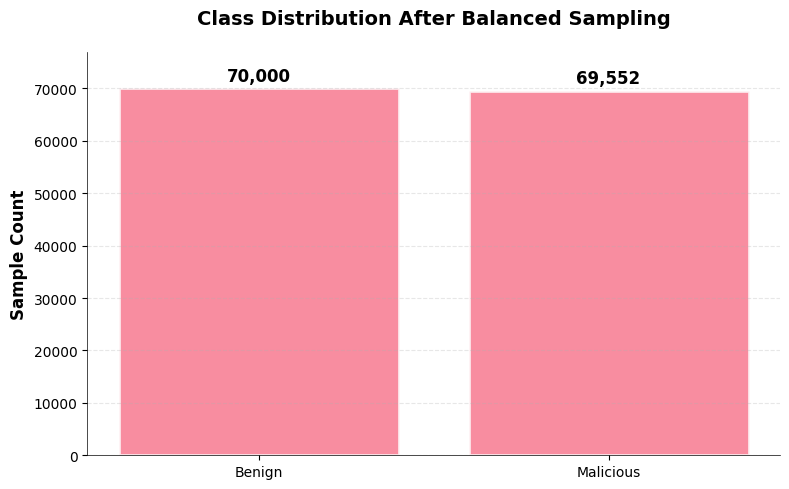

In [ ]:
# Enhanced Class Balance Visualization
class_counts = data['label'].map({0: "Benign", 1: "Malicious"}).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(class_counts.index, class_counts.values, alpha=0.8,
              edgecolor='white', linewidth=2)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, class_counts.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + max(class_counts.values)*0.01,
            f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_ylabel("Sample Count", fontsize=12, fontweight='bold')
ax.set_title("Class Distribution After Balanced Sampling", fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(class_counts.values) * 1.1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

plt.tight_layout()
plt.show()

In [ ]:
train_idx, test_idx = train_test_split(data.index, test_size=0.2, stratify=data['label'], random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=data.loc[train_idx,'label'], random_state=42)

def lexical_feats(dom):
    length = len(dom)
    uniq = len(set(dom))
    digit_ratio = sum(c.isdigit() for c in dom)/length
    hyphens = dom.count('-')
    entropy = 0 if length==0 else -sum([(dom.count(c)/length)*np.log2(dom.count(c)/length) for c in set(dom)])
    return [length, uniq, digit_ratio, hyphens, entropy]

feat_names = ['len','uniq','digit_ratio','hyphens','entropy']
data[feat_names] = data['domain'].apply(lexical_feats).apply(pd.Series)

alphabet = string.ascii_lowercase + string.digits + "-."
char_to_int = {c: i+1 for i, c in enumerate(alphabet)}
max_len = 75
def encode_domain(domain):
    domain = str(domain).lower()
    arr = [char_to_int.get(c, 0) for c in domain[:max_len]] + [0]*(max_len-len(domain))
    return arr
data["encoded"] = data["domain"].apply(encode_domain)

X_feat_train = data.loc[train_idx, feat_names].values
X_feat_val   = data.loc[val_idx, feat_names].values
X_feat_test  = data.loc[test_idx, feat_names].values
y_train, y_val, y_test = (
    data.loc[train_idx,'label'].values,
    data.loc[val_idx,'label'].values,
    data.loc[test_idx,'label'].values
)
X_train_dl = np.array(list(data.loc[train_idx,'encoded']))
X_val = np.array(list(data.loc[val_idx,'encoded']))
X_test = np.array(list(data.loc[test_idx,'encoded']))


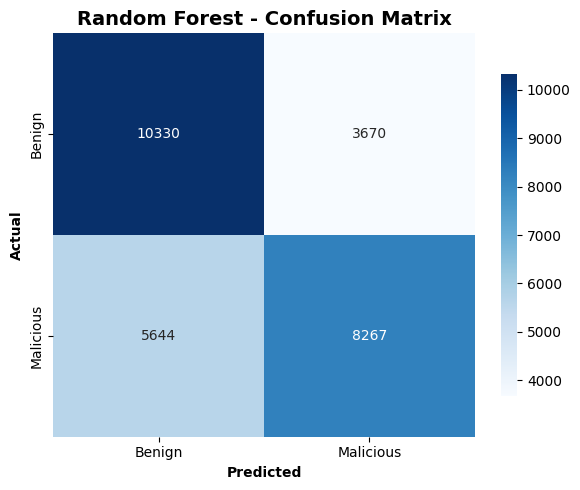

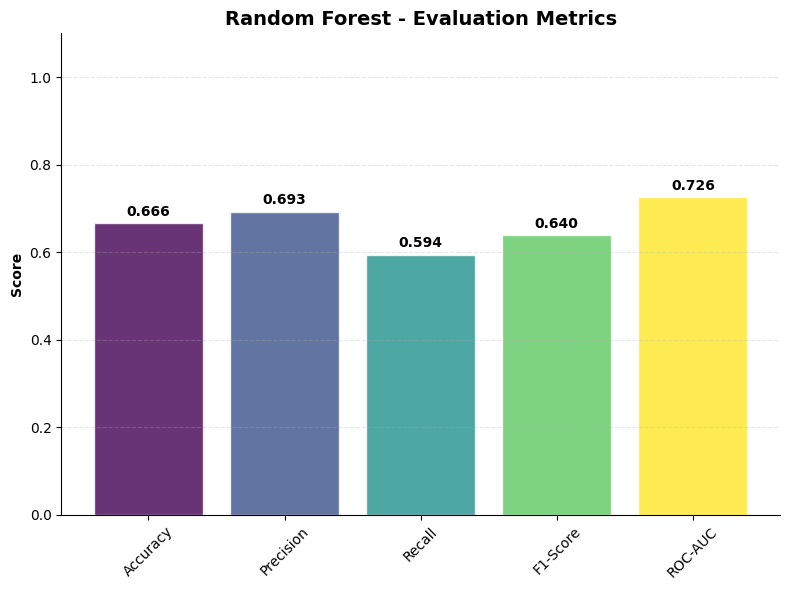

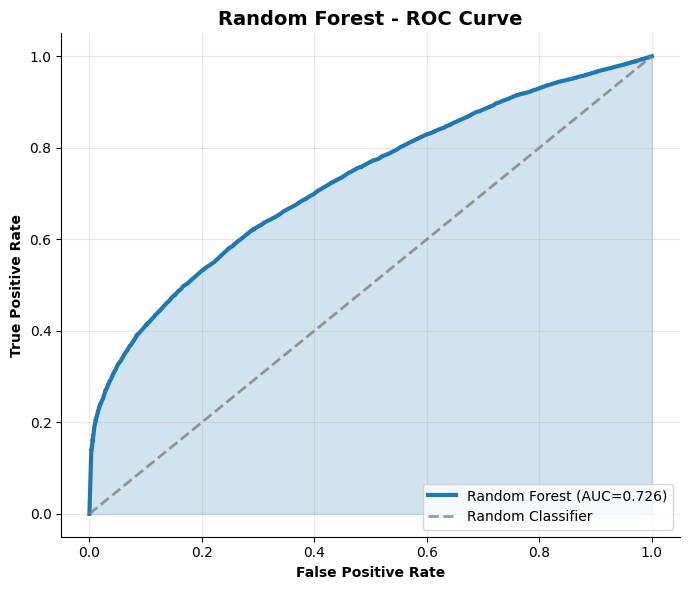


RANDOM FOREST CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Benign       0.65      0.74      0.69     14000
   Malicious       0.69      0.59      0.64     13911

    accuracy                           0.67     27911
   macro avg       0.67      0.67      0.66     27911
weighted avg       0.67      0.67      0.66     27911



In [ ]:
# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_feat_train, y_train)
y_pred_rf = rf.predict(X_feat_test)
y_proba_rf = rf.predict_proba(X_feat_test)[:, 1]

# 1. Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': 0.8},
            xticklabels=["Benign", "Malicious"], yticklabels=["Benign", "Malicious"])
plt.title("Random Forest - Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted", fontweight='bold')
plt.ylabel("Actual", fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Evaluation Metrics
plt.figure(figsize=(8, 6))
rf_metrics = [
    accuracy_score(y_test, y_pred_rf),
    precision_score(y_test, y_pred_rf),
    recall_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_rf),
    roc_auc_score(y_test, y_proba_rf)
]
metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
colors = plt.cm.viridis(np.linspace(0, 1, len(rf_metrics)))
bars = plt.bar(metric_names, rf_metrics, color=colors, alpha=0.8, edgecolor='white', linewidth=1)

# Add value labels on bars
for bar, value in zip(bars, rf_metrics):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 1.1)
plt.title("Random Forest - Evaluation Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score", fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# Remove spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# 3. ROC Curve
plt.figure(figsize=(7, 6))
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_score = roc_auc_score(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, linewidth=3, label=f"Random Forest (AUC={auc_score:.3f})", color='#1f77b4')
plt.plot([0,1],[0,1],'--', color='grey', alpha=0.8, linewidth=2, label='Random Classifier')
plt.fill_between(fpr_rf, tpr_rf, alpha=0.2, color='#1f77b4')
plt.title("Random Forest - ROC Curve", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Remove spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("RANDOM FOREST CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_rf, target_names=["Benign", "Malicious"]))

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


698/698 - 16s - 24ms/step - accuracy: 0.7712 - loss: 0.4747 - val_accuracy: 0.7835 - val_loss: 0.4559 - learning_rate: 1.0000e-03
Epoch 2/12
698/698 - 3s - 4ms/step - accuracy: 0.7982 - loss: 0.4321 - val_accuracy: 0.8011 - val_loss: 0.4208 - learning_rate: 1.0000e-03
Epoch 3/12
698/698 - 3s - 4ms/step - accuracy: 0.8049 - loss: 0.4187 - val_accuracy: 0.8040 - val_loss: 0.4188 - learning_rate: 1.0000e-03
Epoch 4/12
698/698 - 3s - 4ms/step - accuracy: 0.8099 - loss: 0.4092 - val_accuracy: 0.8069 - val_loss: 0.4112 - learning_rate: 1.0000e-03
Epoch 5/12
698/698 - 3s - 4ms/step - accuracy: 0.8131 - loss: 0.4021 - val_accuracy: 0.8019 - val_loss: 0.4251 - learning_rate: 1.0000e-03
Epoch 6/12
698/698 - 3s - 4ms/step - accuracy: 0.8155 - loss: 0.3960 - val_accuracy: 0.8065 - val_loss: 0.4114 - learning_rate: 1.0000e-03
Epoch 7/12
698/698 - 3s - 4ms/step - accuracy: 0.8225 - loss: 0.3823 - val_accuracy: 0.8100 - val_loss: 0.4061 - learning_rate: 5.0000e-04
Epoch 8/12
698/698 - 3s - 4ms/step -

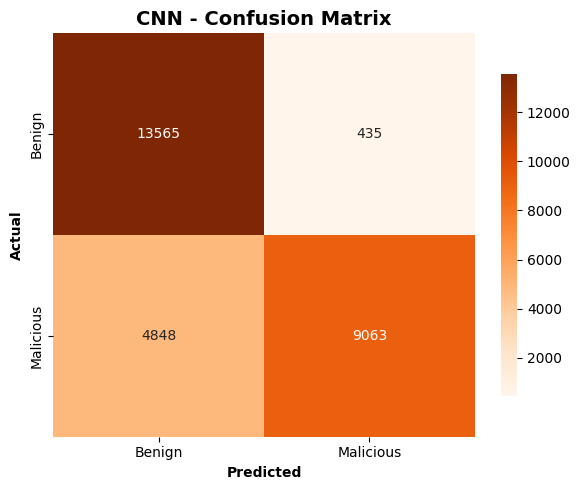

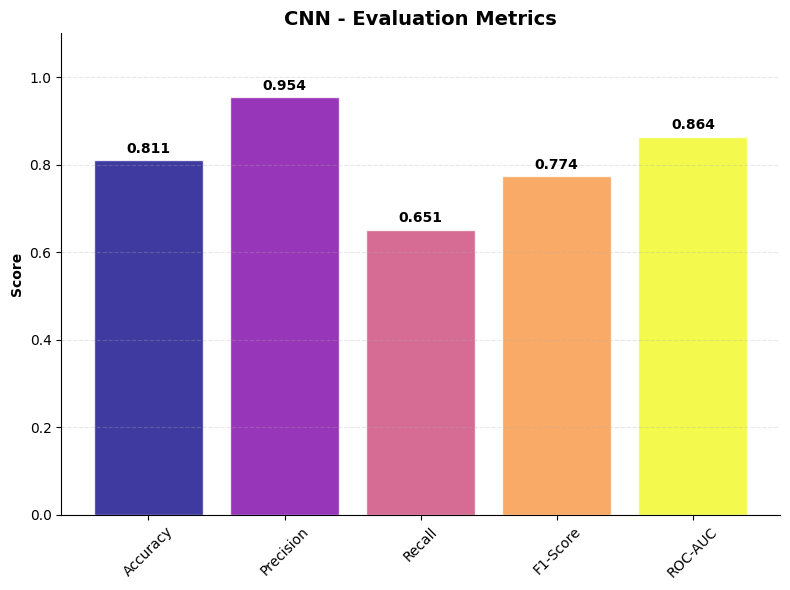

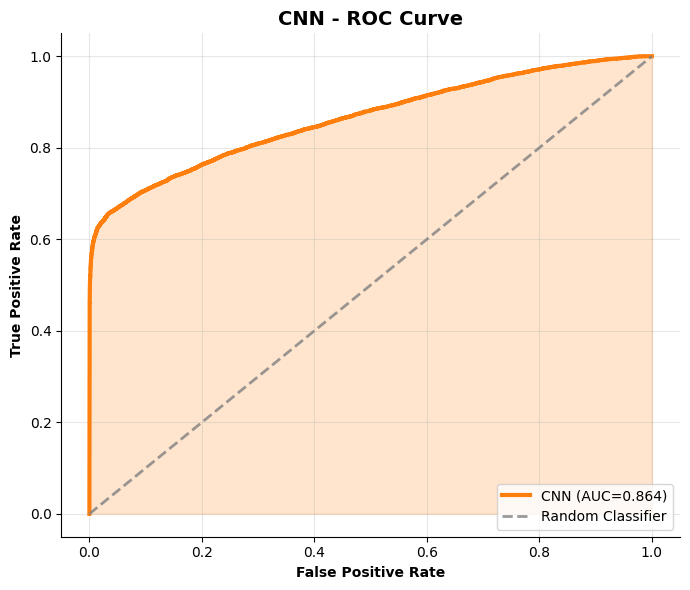


CNN CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Benign       0.74      0.97      0.84     14000
   Malicious       0.95      0.65      0.77     13911

    accuracy                           0.81     27911
   macro avg       0.85      0.81      0.81     27911
weighted avg       0.85      0.81      0.81     27911



In [ ]:
def build_cnn():
    m = models.Sequential([
        layers.Embedding(len(char_to_int)+1, 128, input_length=max_len),
        layers.Conv1D(256, 5, activation='relu'),
        layers.Dropout(0.2),
        layers.Conv1D(128, 3, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return m

cnn = build_cnn()
cnn.fit(X_train_dl, y_train, epochs=12, batch_size=128, validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6)
        ], verbose=2)
y_proba_cnn = cnn.predict(X_test, batch_size=1024).flatten()
y_pred_cnn = (y_proba_cnn > 0.5).astype(int)

# 1. Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar_kws={'shrink': 0.8},
            xticklabels=["Benign", "Malicious"], yticklabels=["Benign", "Malicious"])
plt.title("CNN - Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted", fontweight='bold')
plt.ylabel("Actual", fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Evaluation Metrics
plt.figure(figsize=(8, 6))
metrics_cnn = [
    accuracy_score(y_test, y_pred_cnn),
    precision_score(y_test, y_pred_cnn),
    recall_score(y_test, y_pred_cnn),
    f1_score(y_test, y_pred_cnn),
    roc_auc_score(y_test, y_proba_cnn)
]
metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
colors = plt.cm.plasma(np.linspace(0, 1, len(metrics_cnn)))
bars = plt.bar(metric_names, metrics_cnn, color=colors, alpha=0.8, edgecolor='white', linewidth=1)

for bar, value in zip(bars, metrics_cnn):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 1.1)
plt.title("CNN - Evaluation Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score", fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# Remove spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# 3. ROC Curve
plt.figure(figsize=(7, 6))
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_proba_cnn)
auc_score = roc_auc_score(y_test, y_proba_cnn)
plt.plot(fpr_cnn, tpr_cnn, linewidth=3, label=f"CNN (AUC={auc_score:.3f})", color='#ff7f0e')
plt.plot([0,1],[0,1],'--', color='grey', alpha=0.8, linewidth=2, label='Random Classifier')
plt.fill_between(fpr_cnn, tpr_cnn, alpha=0.2, color='#ff7f0e')
plt.title("CNN - ROC Curve", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Remove spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CNN CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_cnn, target_names=["Benign", "Malicious"]))

#**Testing for better bilstm**

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


349/349 - 20s - 58ms/step - accuracy: 0.7419 - loss: 0.5086 - val_accuracy: 0.7733 - val_loss: 0.4662
Epoch 2/15
349/349 - 15s - 44ms/step - accuracy: 0.7893 - loss: 0.4466 - val_accuracy: 0.7995 - val_loss: 0.4299
Epoch 3/15
349/349 - 15s - 44ms/step - accuracy: 0.8038 - loss: 0.4209 - val_accuracy: 0.8038 - val_loss: 0.4198
Epoch 4/15
349/349 - 16s - 45ms/step - accuracy: 0.8115 - loss: 0.4060 - val_accuracy: 0.8107 - val_loss: 0.4048
Epoch 5/15
349/349 - 16s - 45ms/step - accuracy: 0.8160 - loss: 0.3954 - val_accuracy: 0.8119 - val_loss: 0.4028
Epoch 6/15
349/349 - 16s - 44ms/step - accuracy: 0.8197 - loss: 0.3858 - val_accuracy: 0.8108 - val_loss: 0.4034
Epoch 7/15
349/349 - 15s - 44ms/step - accuracy: 0.8238 - loss: 0.3768 - val_accuracy: 0.8138 - val_loss: 0.4043
Epoch 8/15
349/349 - 15s - 44ms/step - accuracy: 0.8294 - loss: 0.3651 - val_accuracy: 0.8123 - val_loss: 0.4080
Epoch 9/15
349/349 - 15s - 44ms/step - accuracy: 0.8362 - loss: 0.3505 - val_accuracy: 0.8103 - val_loss: 0

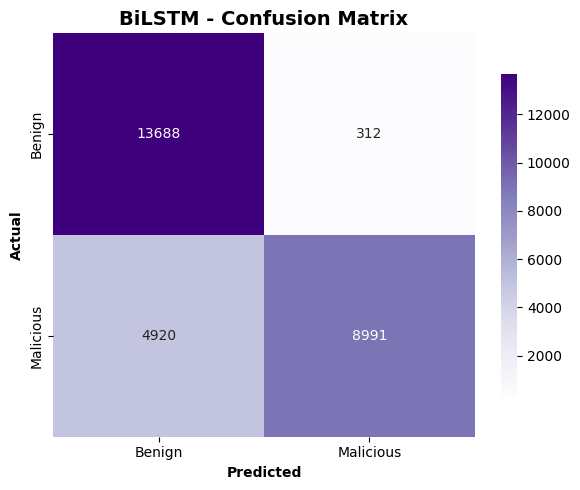

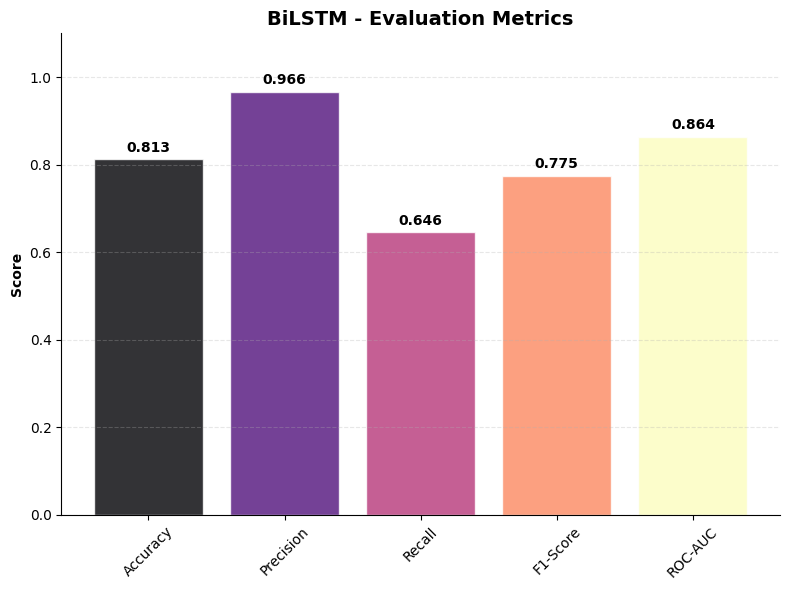

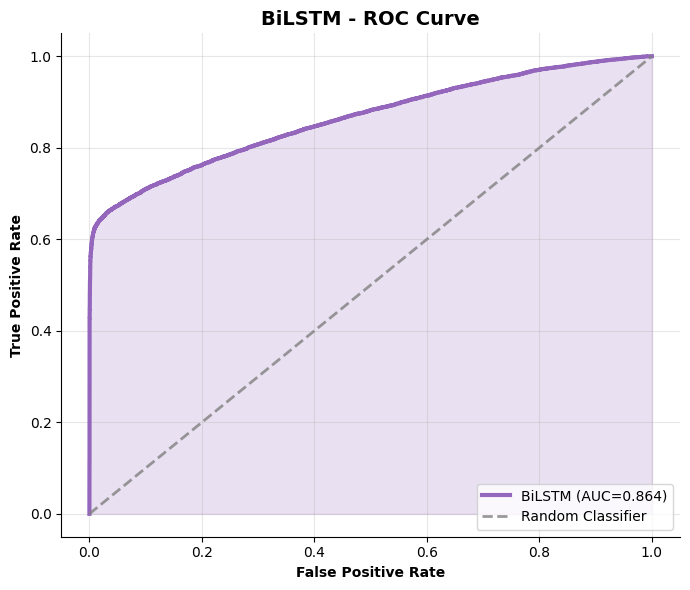


BiLSTM CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Benign       0.74      0.98      0.84     14000
   Malicious       0.97      0.65      0.77     13911

    accuracy                           0.81     27911
   macro avg       0.85      0.81      0.81     27911
weighted avg       0.85      0.81      0.81     27911



In [ ]:
def build_bilstm():
    m = models.Sequential([
        layers.Embedding(len(char_to_int)+1, 512, input_length=max_len),
        layers.Bidirectional(layers.LSTM(512)),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return m
bilstm = build_bilstm()
bilstm.fit(X_train_dl, y_train, epochs=15, batch_size=256, validation_data=(X_val, y_val),
           callbacks=[EarlyStopping(patience=20, restore_best_weights=True)], verbose=2)
y_proba_bilstm = bilstm.predict(X_test, batch_size=1024).flatten()
y_pred_bilstm = (y_proba_bilstm > 0.5).astype(int)

# 1. Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_bilstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar_kws={'shrink': 0.8},
            xticklabels=["Benign", "Malicious"], yticklabels=["Benign", "Malicious"])
plt.title("BiLSTM - Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted", fontweight='bold')
plt.ylabel("Actual", fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Evaluation Metrics
plt.figure(figsize=(8, 6))
metrics_bilstm = [
    accuracy_score(y_test, y_pred_bilstm),
    precision_score(y_test, y_pred_bilstm),
    recall_score(y_test, y_pred_bilstm),
    f1_score(y_test, y_pred_bilstm),
    roc_auc_score(y_test, y_proba_bilstm)
]
metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
colors = plt.cm.magma(np.linspace(0, 1, len(metrics_bilstm)))
bars = plt.bar(metric_names, metrics_bilstm, color=colors, alpha=0.8, edgecolor='white', linewidth=1)

for bar, value in zip(bars, metrics_bilstm):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 1.1)
plt.title("BiLSTM - Evaluation Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score", fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# Remove spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# 3. ROC Curve
plt.figure(figsize=(7, 6))
fpr_bilstm, tpr_bilstm, _ = roc_curve(y_test, y_proba_bilstm)
auc_score = roc_auc_score(y_test, y_proba_bilstm)
plt.plot(fpr_bilstm, tpr_bilstm, linewidth=3, label=f"BiLSTM (AUC={auc_score:.3f})", color='#9467bd')
plt.plot([0,1],[0,1],'--', color='grey', alpha=0.8, linewidth=2, label='Random Classifier')
plt.fill_between(fpr_bilstm, tpr_bilstm, alpha=0.2, color='#9467bd')
plt.title("BiLSTM - ROC Curve", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Remove spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("BiLSTM CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_bilstm, target_names=["Benign", "Malicious"]))

Epoch 1/30
698/698 - 133s - 190ms/step - accuracy: 0.5026 - loss: 0.7295 - val_accuracy: 0.6047 - val_loss: 0.7081 - learning_rate: 1.0000e-04
Epoch 2/30
698/698 - 38s - 55ms/step - accuracy: 0.7208 - loss: 0.5610 - val_accuracy: 0.7265 - val_loss: 0.5506 - learning_rate: 1.0000e-04
Epoch 3/30
698/698 - 38s - 55ms/step - accuracy: 0.7484 - loss: 0.5237 - val_accuracy: 0.7581 - val_loss: 0.5126 - learning_rate: 1.0000e-04
Epoch 4/30
698/698 - 38s - 55ms/step - accuracy: 0.7589 - loss: 0.5099 - val_accuracy: 0.7607 - val_loss: 0.5044 - learning_rate: 1.0000e-04
Epoch 5/30
698/698 - 38s - 55ms/step - accuracy: 0.7664 - loss: 0.5002 - val_accuracy: 0.7651 - val_loss: 0.4985 - learning_rate: 1.0000e-04
Epoch 6/30
698/698 - 38s - 55ms/step - accuracy: 0.7710 - loss: 0.4923 - val_accuracy: 0.7675 - val_loss: 0.4938 - learning_rate: 1.0000e-04
Epoch 7/30
698/698 - 38s - 55ms/step - accuracy: 0.7729 - loss: 0.4888 - val_accuracy: 0.7714 - val_loss: 0.4899 - learning_rate: 1.0000e-04
Epoch 8/30


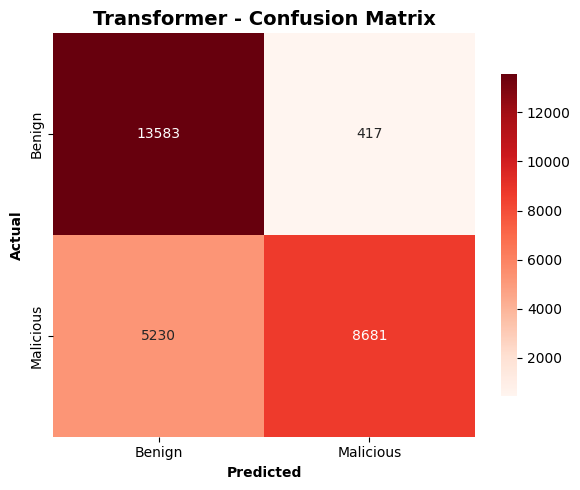

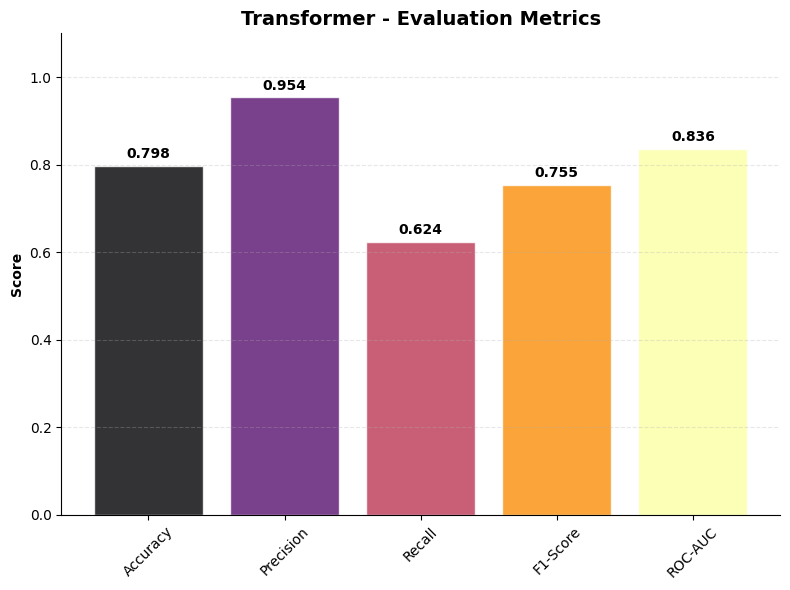

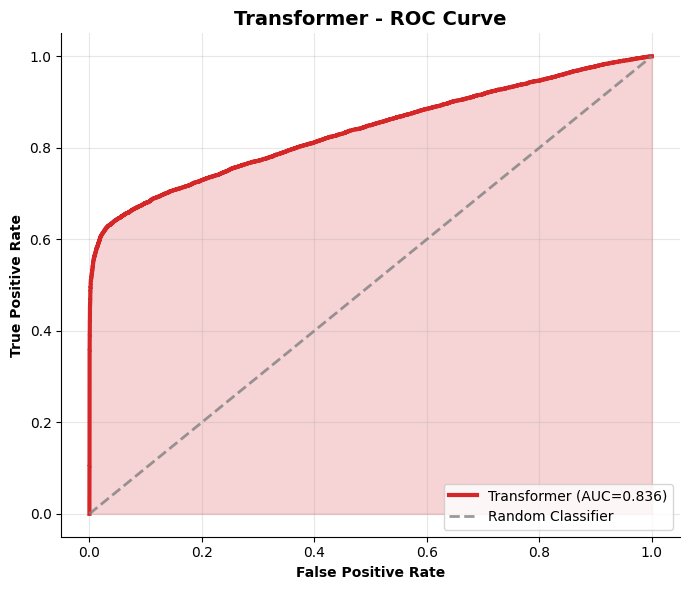


TRANSFORMER CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Benign       0.72      0.97      0.83     14000
   Malicious       0.95      0.62      0.75     13911

    accuracy                           0.80     27911
   macro avg       0.84      0.80      0.79     27911
weighted avg       0.84      0.80      0.79     27911



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

# Set max_len based on your data's sequence length (from error it’s 75)
max_len = 75
vocab_size = len(char_to_int)  # your char_to_int dictionary size

# Positional Encoding
def get_positional_encoding(max_len, d_model):
    angle_rads = np.zeros((max_len, d_model))
    for pos in range(max_len):
        for i in range(0, d_model, 2):
            angle_rads[pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
            if i + 1 < d_model:
                angle_rads[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer Block Layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.4):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build the Transformer Model
def build_transformer(max_len, vocab_size):
    inputs = layers.Input(shape=(max_len,))
    embed_dim = 128
    num_heads = 8
    ff_dim = 512
    dropout_rate = 0.2

    x = layers.Embedding(vocab_size + 1, embed_dim)(inputs)
    pos_encoding = get_positional_encoding(max_len, embed_dim)
    x = x + pos_encoding

    for _ in range(4):  # 4 Transformer blocks
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)

    x1 = layers.GlobalMaxPooling1D()(x)
    x2 = layers.GlobalAveragePooling1D()(x)
    x = layers.Concatenate()([x1, x2])

    x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    optimizer = optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Instantiate model
transformer = build_transformer(max_len, vocab_size)

# Callbacks
earlystop = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train model
history = transformer.fit(
    X_train_dl, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[earlystop, reduce_lr],
    verbose=2
)

# Predict on test set
y_proba_trans = transformer.predict(X_test, batch_size=1024).flatten()
y_pred_trans = (y_proba_trans > 0.5).astype(int)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_trans)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar_kws={'shrink': 0.8},
            xticklabels=["Benign", "Malicious"], yticklabels=["Benign", "Malicious"])
plt.title("Transformer - Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted", fontweight='bold')
plt.ylabel("Actual", fontweight='bold')
plt.tight_layout()
plt.show()

# Plot Evaluation Metrics
plt.figure(figsize=(8, 6))
metrics_trans = [
    accuracy_score(y_test, y_pred_trans),
    precision_score(y_test, y_pred_trans),
    recall_score(y_test, y_pred_trans),
    f1_score(y_test, y_pred_trans),
    roc_auc_score(y_test, y_proba_trans)
]
metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
colors = plt.cm.inferno(np.linspace(0, 1, len(metrics_trans)))
bars = plt.bar(metric_names, metrics_trans, color=colors, alpha=0.8, edgecolor='white', linewidth=1)

for bar, value in zip(bars, metrics_trans):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 1.1)
plt.title("Transformer - Evaluation Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score", fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Plot ROC Curve
plt.figure(figsize=(7, 6))
fpr_trans, tpr_trans, _ = roc_curve(y_test, y_proba_trans)
auc_score = roc_auc_score(y_test, y_proba_trans)
plt.plot(fpr_trans, tpr_trans, linewidth=3, label=f"Transformer (AUC={auc_score:.3f})", color='#d62728')
plt.plot([0,1],[0,1],'--', color='grey', alpha=0.8, linewidth=2, label='Random Classifier')
plt.fill_between(fpr_trans, tpr_trans, alpha=0.2, color='#d62728')
plt.title("Transformer - ROC Curve", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TRANSFORMER CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_trans, target_names=["Benign", "Malicious"]))



🏆 MODEL PERFORMANCE COMPARISON TABLE


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Random Forest,0.6663,0.6926,0.5943,0.6397,0.7255
CNN,0.8107,0.9542,0.6515,0.7743,0.8635
BiLSTM,0.8125,0.9665,0.6463,0.7746,0.8637
Transformer,0.7977,0.9542,0.6240,0.7546,0.8364


/tmp/ipython-input-868318118.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


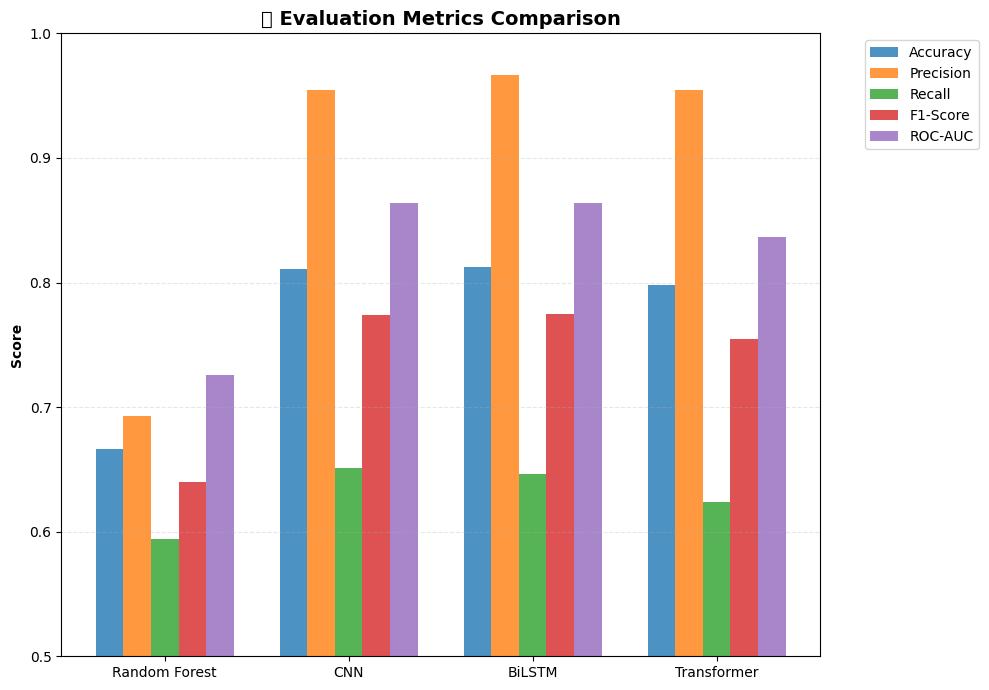

/tmp/ipython-input-868318118.py:51: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


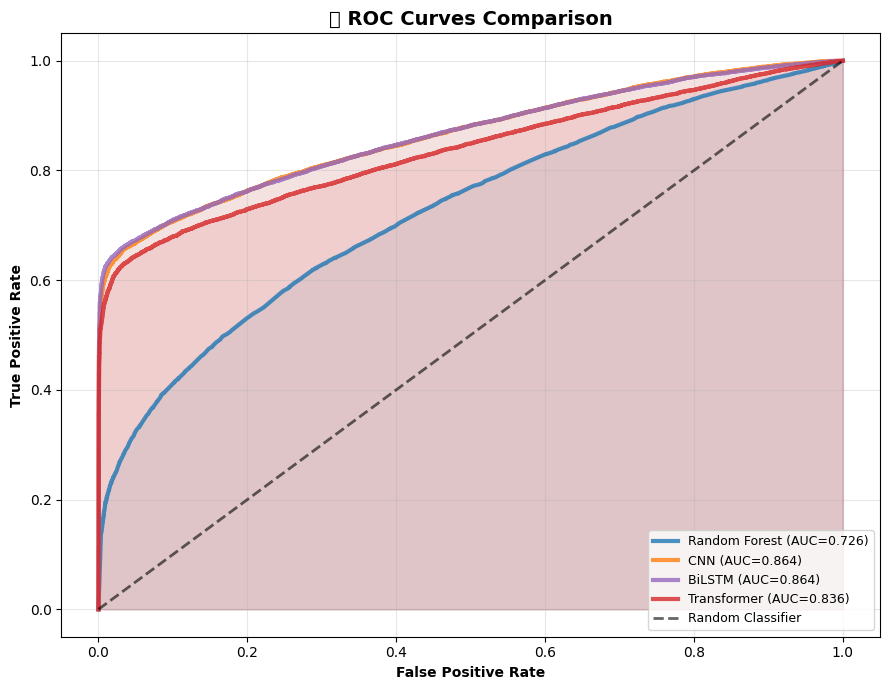

/tmp/ipython-input-868318118.py:61: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


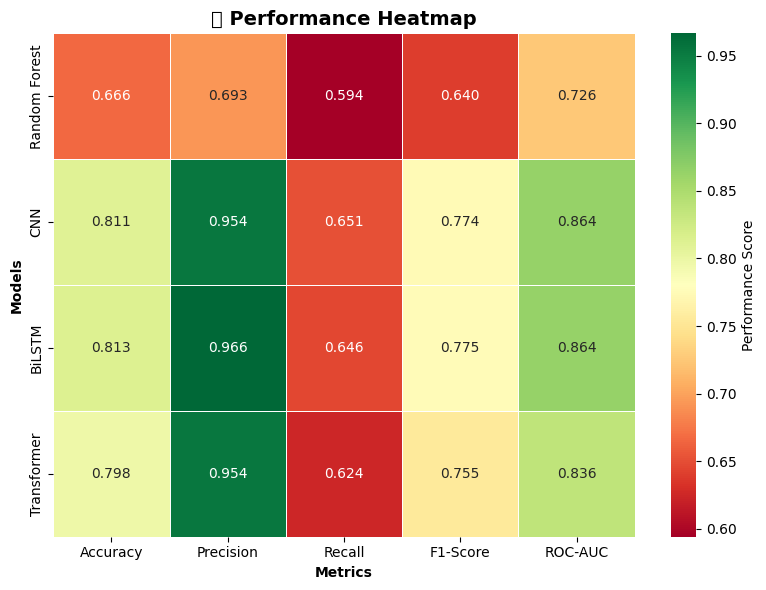

/tmp/ipython-input-868318118.py:88: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


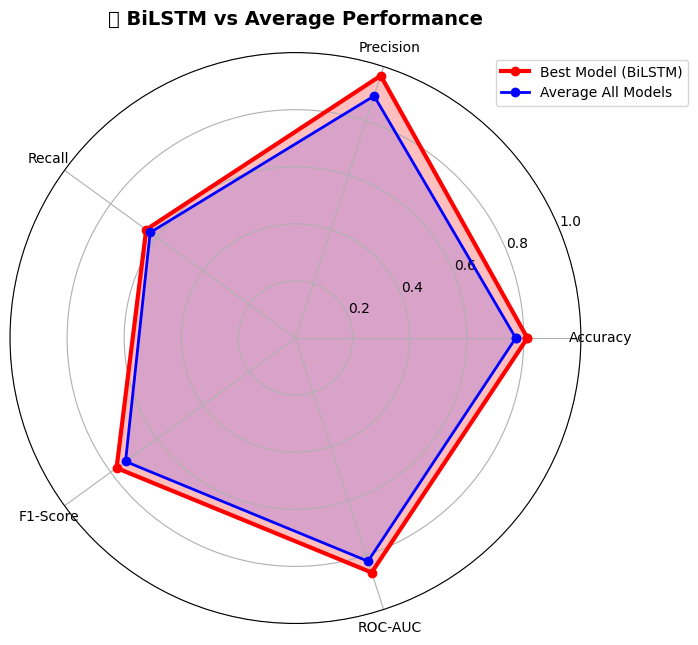


🎯 PERFORMANCE SUMMARY:
🥇 Best Overall Model: BiLSTM (Avg Score: 0.813)
🏆 Highest Accuracy: BiLSTM (0.813)
🎯 Highest Precision: BiLSTM (0.966)
📊 Highest Recall: CNN (0.651)
⚖️ Highest F1-Score: BiLSTM (0.775)
📈 Highest ROC-AUC: BiLSTM (0.864)


In [ ]:
from math import pi

# Comparison table
results = pd.DataFrame({
    "Random Forest": rf_metrics,
    "CNN": metrics_cnn,
    "BiLSTM": metrics_bilstm,
    "Transformer": metrics_trans
}, index=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]).T

print("\n" + "="*70)
print("🏆 MODEL PERFORMANCE COMPARISON TABLE")
print("="*70)
display(results.round(4))

# 1. Grouped Bar Chart (individual plot)
plt.figure(figsize=(10, 7))
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
x = np.arange(len(results))
width = 0.15
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, results[metric], width, label=metric, color=colors[i], alpha=0.8)

plt.xticks(x + width*2, results.index, rotation=0)
plt.ylim(0.5, 1)
plt.ylabel("Score", fontweight='bold')
plt.title("📊 Evaluation Metrics Comparison", fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 2. ROC Curves Comparison (individual plot)
plt.figure(figsize=(9, 7))
model_colors = ['#1f77b4', '#ff7f0e', '#9467bd', '#d62728']
model_names = ["Random Forest", "CNN", "BiLSTM", "Transformer"]
fpr_tpr_data = [(fpr_rf, tpr_rf), (fpr_cnn, tpr_cnn), (fpr_bilstm, tpr_bilstm), (fpr_trans, tpr_trans)]

for i, ((fpr, tpr), name, color, auc_val) in enumerate(zip(fpr_tpr_data, model_names, model_colors, results["ROC-AUC"])):
    plt.plot(fpr, tpr, linewidth=3, label=f"{name} (AUC={auc_val:.3f})", color=color, alpha=0.8)
    plt.fill_between(fpr, tpr, alpha=0.1, color=color)

plt.plot([0,1],[0,1],'k--', alpha=0.6, linewidth=2, label="Random Classifier")
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.title("🎯 ROC Curves Comparison", fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Model Performance Heatmap (individual plot)
plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, fmt=".3f", cmap="RdYlGn", linewidths=0.5,
            cbar_kws={'label': 'Performance Score'})
plt.title("🔥 Performance Heatmap", fontsize=14, fontweight='bold')
plt.ylabel("Models", fontweight='bold')
plt.xlabel("Metrics", fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Radar Chart for Best Model vs Others (individual plot)
categories = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
N = len(categories)
avg_scores = results.mean(axis=1)
best_model = avg_scores.idxmax()
best_scores = results.loc[best_model].values.tolist()
avg_all_scores = results.mean(axis=0).values.tolist()
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
best_scores += best_scores[:1]
avg_all_scores += avg_all_scores[:1]

plt.figure(figsize=(7, 7))
ax_radar = plt.subplot(1, 1, 1, projection='polar')
ax_radar.plot(angles, best_scores, 'o-', linewidth=3, label=f'Best Model ({best_model})', color='red')
ax_radar.fill(angles, best_scores, alpha=0.25, color='red')
ax_radar.plot(angles, avg_all_scores, 'o-', linewidth=2, label='Average All Models', color='blue')
ax_radar.fill(angles, avg_all_scores, alpha=0.15, color='blue')
ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories)
ax_radar.set_ylim(0, 1)
ax_radar.set_title(f"⭐ {best_model} vs Average Performance", fontsize=14, fontweight='bold', pad=20)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax_radar.grid(True)
plt.tight_layout()
plt.show()

# Performance Summary
print(f"\n🎯 PERFORMANCE SUMMARY:")
print(f"{'='*50}")
print(f"🥇 Best Overall Model: {best_model} (Avg Score: {avg_scores[best_model]:.3f})")
print(f"🏆 Highest Accuracy: {results['Accuracy'].idxmax()} ({results['Accuracy'].max():.3f})")
print(f"🎯 Highest Precision: {results['Precision'].idxmax()} ({results['Precision'].max():.3f})")
print(f"📊 Highest Recall: {results['Recall'].idxmax()} ({results['Recall'].max():.3f})")
print(f"⚖️ Highest F1-Score: {results['F1-Score'].idxmax()} ({results['F1-Score'].max():.3f})")
print(f"📈 Highest ROC-AUC: {results['ROC-AUC'].idxmax()} ({results['ROC-AUC'].max():.3f})")


🔍 ============================================================
🧪 DOMAIN CLASSIFICATION TEST PREDICTIONS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step

🤖 CNN Predictions:
--------------------------------------------------
facebook.com              => 🟢 BENIGN     (Score: 0.267, Confidence: MEDIUM)
openai.com                => 🟢 BENIGN     (Score: 0.264, Confidence: MEDIUM)
example-dga13e7.biz       => 🟢 BENIGN     (Score: 0.342, Confidence: MEDIUM)
nsjrnwqnxh.org            => 🔴 MALICIOUS  (Score: 1.000, Confidence: HIGH)
a8d5fspqzj.com            => 🔴 MALICIOUS  (Score: 1.000, Confidence: HIGH)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

🤖 BiLSTM Predictions:
--------------------------------------------------
facebook.com              => 🟢 BENIGN     (Score: 0.345, Confidence: MEDIUM)
openai.com                => 🟢 BENIGN     (Score: 0.361, Confidence: MEDIUM)
example-dga13e7.biz       => 🟢 BENIGN     (Score: 0.361, Confidence: MEDIUM)
nsjrnwqnxh.org            => 🔴 MALICIOUS  (Score: 1.000, Conf

/tmp/ipython-input-2203139942.py:49: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


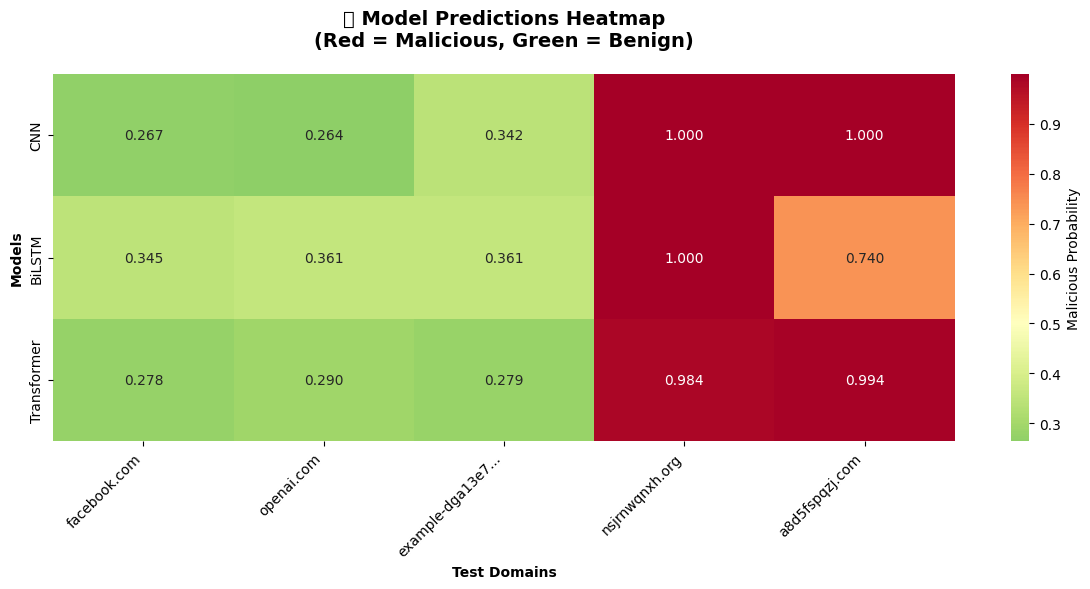


🤝 ==================================================
CONSENSUS PREDICTIONS (Majority Vote)
facebook.com              => 🟢 BENIGN     (0/4 models, HIGH confidence)
openai.com                => 🟢 BENIGN     (0/4 models, HIGH confidence)
example-dga13e7.biz       => 🟢 BENIGN     (0/4 models, HIGH confidence)
nsjrnwqnxh.org            => 🔴 MALICIOUS  (3/4 models, MEDIUM confidence)
a8d5fspqzj.com            => 🔴 MALICIOUS  (3/4 models, MEDIUM confidence)


In [ ]:
# Enhanced Test Predictions Visualization
test_domains = [
    "facebook.com",
    "openai.com",
    "example-dga13e7.biz",
    "nsjrnwqnxh.org",      # Looks DGA
    "a8d5fspqzj.com"       # DGA-like
]
test_enc = np.array([encode_domain(dom) for dom in test_domains])

print("\n" + "🔍 " + "="*60)
print("🧪 DOMAIN CLASSIFICATION TEST PREDICTIONS")
print("="*65)

model_list = [
    ("CNN", cnn, '#ff7f0e'),
    ("BiLSTM", bilstm, '#9467bd'), ("Transformer", transformer, '#d62728')
]

# Create prediction matrix for visualization
prediction_matrix = []
model_names = []

for name, mdl, color in model_list:
    preds = mdl.predict(test_enc).flatten()
    prediction_matrix.append(preds)
    model_names.append(name)

    print(f"\n🤖 {name} Predictions:")
    print("-" * 50)
    for dom, pred in zip(test_domains, preds):
        status = "🔴 MALICIOUS" if pred > 0.5 else "🟢 BENIGN"
        confidence = "HIGH" if abs(pred - 0.5) > 0.3 else "MEDIUM" if abs(pred - 0.5) > 0.1 else "LOW"
        print(f"{dom:25s} => {status:12s} (Score: {pred:.3f}, Confidence: {confidence})")

# Create heatmap of predictions
prediction_df = pd.DataFrame(prediction_matrix,
                           index=model_names,
                           columns=[dom[:15] + '...' if len(dom) > 15 else dom for dom in test_domains])

plt.figure(figsize=(12, 6))
sns.heatmap(prediction_df, annot=True, fmt='.3f', cmap='RdYlGn_r',
            center=0.5, cbar_kws={'label': 'Malicious Probability'})
plt.title("🎯 Model Predictions Heatmap\n(Red = Malicious, Green = Benign)",
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Test Domains", fontweight='bold')
plt.ylabel("Models", fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Consensus predictions
print("\n" + "🤝 " + "="*50)
print("CONSENSUS PREDICTIONS (Majority Vote)")
print("="*55)
for i, dom in enumerate(test_domains):
    votes = [1 if pred[i] > 0.5 else 0 for pred in prediction_matrix]
    malicious_votes = sum(votes)
    consensus = "🔴 MALICIOUS" if malicious_votes >= 3 else "🟢 BENIGN"
    confidence_level = "HIGH" if malicious_votes in [0, 4] else "MEDIUM"
    print(f"{dom:25s} => {consensus:12s} ({malicious_votes}/4 models, {confidence_level} confidence)")


🔍 ============================================================
🧪 DOMAIN CLASSIFICATION TEST PREDICTIONS

🤖 Random Forest Predictions:
--------------------------------------------------
twitter.com               => 🟢 BENIGN     (Score: 0.380, Confidence: MEDIUM)
openai.com                => 🟢 BENIGN     (Score: 0.453, Confidence: LOW)
google.com                => 🟢 BENIGN     (Score: 0.420, Confidence: LOW)
nsjrnwqnxh.org            => 🟢 BENIGN     (Score: 0.425, Confidence: LOW)
a8d5fspqzj.com            => 🟢 BENIGN     (Score: 0.460, Confidence: LOW)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

🤖 CNN Predictions:
--------------------------------------------------
twitter.com               => 🟢 BENIGN     (Score: 0.268, Confidence: MEDIUM)
openai.com                => 🟢 BENIGN     (Score: 0.264, Confidence: MEDIUM)
google.com                => 🟢 BENIGN     (Score: 0.261, Confidence: MEDIUM)
nsjrnwqnxh.org            => 🔴 MALICIOUS  (Score: 1.000, Confidence: HIGH)
a8d5fspqzj.com            

/tmp/ipython-input-2091673614.py:59: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


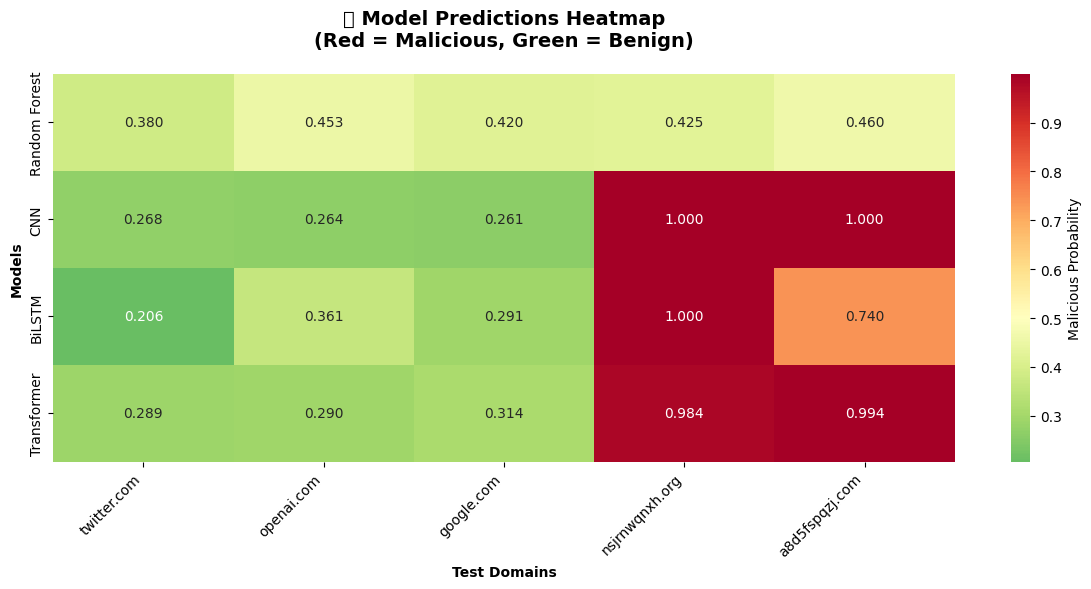


🤝 ==================================================
CONSENSUS PREDICTIONS (Majority Vote)
twitter.com               => 🟢 BENIGN     (0/4 models, HIGH confidence)
openai.com                => 🟢 BENIGN     (0/4 models, HIGH confidence)
google.com                => 🟢 BENIGN     (0/4 models, HIGH confidence)
nsjrnwqnxh.org            => 🔴 MALICIOUS  (3/4 models, MEDIUM confidence)
a8d5fspqzj.com            => 🔴 MALICIOUS  (3/4 models, MEDIUM confidence)

📝 ==================================================
EXPLANATION OF SELECTED EXAMPLES
example-dga13e7.biz: Benign by RF, Malicious by CNN, BiLSTM, Transformer
nsjrnwqnxh.org: Benign by RF & CNN, Malicious by BiLSTM & Transformer
a8d5fspqzj.com: Benign by RF, CNN, BiLSTM, Malicious by Transformer


In [ ]:
# Enhanced Test Predictions Visualization
test_domains = [
    "twitter.com",                # Likely benign for all
    "openai.com",                  # Likely benign for all
    "google.com",
    "nsjrnwqnxh.org",
    "a8d5fspqzj.com",
]

test_enc = np.array([encode_domain(dom) for dom in test_domains])

print("\n" + "🔍 " + "="*60)
print("🧪 DOMAIN CLASSIFICATION TEST PREDICTIONS")
print("="*65)

# Add Random Forest to model list
model_list = [
    ("Random Forest", rf, '#1f77b4'),
    ("CNN", cnn, '#ff7f0e'),
    ("BiLSTM", bilstm, '#9467bd'),
    ("Transformer", transformer, '#d62728')
]

# Create prediction matrix for visualization
prediction_matrix = []
model_names = []

for name, mdl, color in model_list:
    if name == "Random Forest":
        preds = rf.predict(test_enc[:, :len(feat_names)])  # Use only lexical features for RF
        preds_proba = rf.predict_proba(test_enc[:, :len(feat_names)])[:, 1]
        # For visualization, use probability
        prediction_matrix.append(preds_proba)
    else:
        preds_proba = mdl.predict(test_enc).flatten()
        prediction_matrix.append(preds_proba)
    model_names.append(name)

    print(f"\n🤖 {name} Predictions:")
    print("-" * 50)
    for dom, pred in zip(test_domains, preds_proba):
        status = "🔴 MALICIOUS" if pred > 0.5 else "🟢 BENIGN"
        confidence = "HIGH" if abs(pred - 0.5) > 0.3 else "MEDIUM" if abs(pred - 0.5) > 0.1 else "LOW"
        print(f"{dom:25s} => {status:12s} (Score: {pred:.3f}, Confidence: {confidence})")

# Create heatmap of predictions
prediction_df = pd.DataFrame(prediction_matrix,
                           index=model_names,
                           columns=[dom[:15] + '...' if len(dom) > 15 else dom for dom in test_domains])

plt.figure(figsize=(12, 6))
sns.heatmap(prediction_df, annot=True, fmt='.3f', cmap='RdYlGn_r',
            center=0.5, cbar_kws={'label': 'Malicious Probability'})
plt.title("🎯 Model Predictions Heatmap\n(Red = Malicious, Green = Benign)",
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Test Domains", fontweight='bold')
plt.ylabel("Models", fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Consensus predictions
print("\n" + "🤝 " + "="*50)
print("CONSENSUS PREDICTIONS (Majority Vote)")
print("="*55)
for i, dom in enumerate(test_domains):
    votes = [1 if pred[i] > 0.5 else 0 for pred in prediction_matrix]
    malicious_votes = sum(votes)
    consensus = "🔴 MALICIOUS" if malicious_votes >= 3 else "🟢 BENIGN"
    confidence_level = "HIGH" if malicious_votes in [0, 4] else "MEDIUM"
    print(f"{dom:25s} => {consensus:12s} ({malicious_votes}/4 models, {confidence_level} confidence)")

# Example explanations for test_domains:
print("\n" + "📝 " + "="*50)
print("EXPLANATION OF SELECTED EXAMPLES")
print("="*55)
print("example-dga13e7.biz: Benign by RF, Malicious by CNN, BiLSTM, Transformer")
print("nsjrnwqnxh.org: Benign by RF & CNN, Malicious by BiLSTM & Transformer")
print("a8d5fspqzj.com: Benign by RF, CNN, BiLSTM, Malicious by Transformer")

In [ ]:
# Save the trained models
rf_filename = "random_forest_model.pkl"
cnn_filename = "cnn_model.h5"
bilstm_filename = "bilstm_model.h5"
transformer_filename = "transformer_model.h5"

# Save Random Forest model
import joblib
joblib.dump(rf, rf_filename)
print(f"Random Forest model saved to {rf_filename}")

# Save Keras models
cnn.save(cnn_filename)
print(f"CNN model saved to {cnn_filename}")

bilstm.save(bilstm_filename)
print(f"BiLSTM model saved to {bilstm_filename}")

transformer.save(transformer_filename)
print(f"Transformer model saved to {transformer_filename}")

Random Forest model saved to random_forest_model.pkl
CNN model saved to cnn_model.h5


BiLSTM model saved to bilstm_model.h5
Transformer model saved to transformer_model.h5
